In [53]:
%matplotlib notebook
import tensorflow as tf
import read
import matplotlib.pyplot as plt
import numpy as np

(176, 208, 176)


<IPython.core.display.Javascript object>


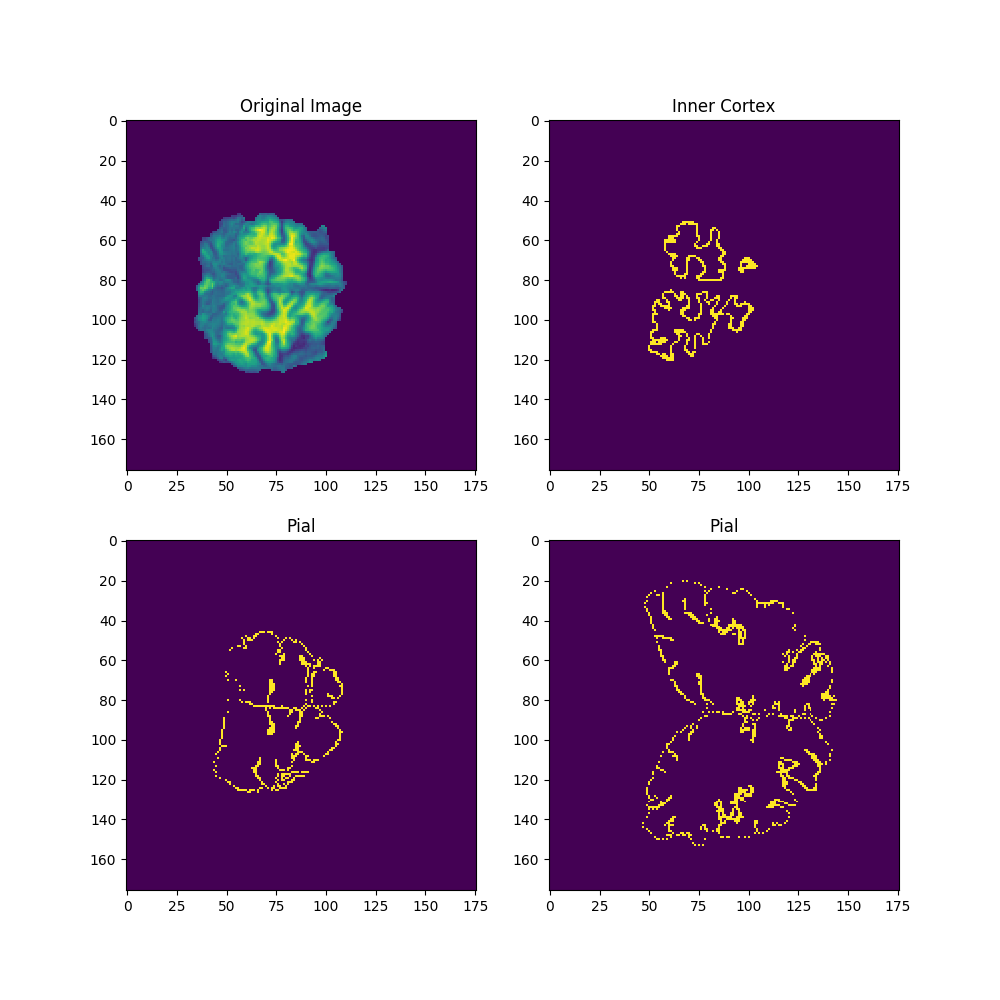

Text(0.5,1,u'Pial')

In [34]:
#test img
img_path = './data/dataset/1/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.bse.nii.gz'
inner_cortex_path = './data/dataset/1/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.inner.cortex.dfs'
pial_cortex_path = './data/dataset/1/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.pial.cortex.dfs'

img = read.read_3d_img(img_path)
inner_cortex_label = read.read_dfs_to_label(inner_cortex_path, img.shape)
pial_cortex_path = read.read_dfs_to_label(pial_cortex_path, img.shape)
print img.shape

slicenum = 30

slice_img = img[:,slicenum,:]
slice_inner_cortex_label = inner_cortex_label[:,slicenum,:]
slice_pial_cortex_path = pial_cortex_path[:,slicenum,:]

fig = plt.figure(figsize=(10,10)) 
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.imshow(slice_img)
ax1.set_title('Original Image')
ax2.imshow(slice_inner_cortex_label)
ax2.set_title('Inner Cortex')
ax3.imshow(slice_pial_cortex_path)
ax3.set_title('Pial')

#plt.show()

In [4]:
from os import listdir
from os.path import isfile, join
import re

X_train = []
Y_train = []
X_test = []
Y_test = []

def loadData(inds):
    data = []
    label = []
    for ind in inds:
        dir_path = './data/dataset/{}/'.format(ind)
        files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
        brain_path = ''
        pial_path = ''
        for file_name in files:
            if file_name.find('bse.nii.gz') > 0:
                brain_path = join(dir_path, file_name)
            elif file_name.find('pial.cortex.dfs') > 0:
                pial_path = join(dir_path, file_name)
                
        img_brain = read.read_3d_img(brain_path)
        label_pail = read.read_dfs_to_label(pial_path, img_brain.shape)
        img_brain = np.transpose(img_brain, (1, 0, 2))
        label_pail = np.transpose(label_pail, (1, 0, 2))
        print('load img {}: {}; Shape {}'.format(ind, brain_path, img_brain.shape))
        print('load pial {}: {}; Shape {}'.format(ind, pial_path, label_pail.shape))
        remove_zeros = np.sum(img_brain, axis=(1, 2)) > 0
        data.append(img_brain[remove_zeros])
        label.append(label_pail[remove_zeros])
        del img_brain
        del label_pail
    
    data = np.concatenate(data)
    label = np.concatenate(label).astype(np.int32)
    return data[:,:,:, np.newaxis], label[:,:,:, np.newaxis]

X_train, Y_train = loadData([1, 2, 3, 5, 6, 7, 9])
X_test, Y_test = loadData([4])

print 'train : data - {}; label - {}'.format(X_train.shape, Y_train.shape)
print 'test : data - {}; label - {}'.format(X_test.shape, Y_test.shape)

load img 1: ./data/dataset/1/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.bse.nii.gz; Shape (208, 176, 176)
load pial 1: ./data/dataset/1/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.pial.cortex.dfs; Shape (208, 176, 176)
load img 2: ./data/dataset/2/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.bse.nii.gz; Shape (208, 176, 176)
load pial 2: ./data/dataset/2/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.pial.cortex.dfs; Shape (208, 176, 176)
load img 3: ./data/dataset/3/OAS1_0003_MR1_mpr_n4_anon_111_t88_gfc.bse.nii.gz; Shape (208, 176, 176)
load pial 3: ./data/dataset/3/OAS1_0003_MR1_mpr_n4_anon_111_t88_gfc.pial.cortex.dfs; Shape (208, 176, 176)
load img 5: ./data/dataset/5/OAS1_0005_MR1_mpr_n4_anon_111_t88_gfc.bse.nii.gz; Shape (208, 176, 176)
load pial 5: ./data/dataset/5/OAS1_0005_MR1_mpr_n4_anon_111_t88_gfc.pial.cortex.dfs; Shape (208, 176, 176)
load img 6: ./data/dataset/6/OAS1_0006_MR1_mpr_n4_anon_111_t88_gfc.bse.nii.gz; Shape (208, 176, 176)
load pial 6: ./data/dataset/6/OAS1_0006_MR1_mpr_n4_anon_111_t88_gfc

In [5]:
#tensorflow network visualization
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [6]:
#utils
def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def conv2d_wd(name, input, kernel_size, stride, num_filter, weight_decay, act = 'Relu'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        init_val = np.sqrt(2.0/(kernel_size*kernel_size*input.get_shape().as_list()[3]))
        W = tf.get_variable('W', filter_shape, tf.float32, tf.random_normal_initializer(0.0, init_val))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
        if weight_decay > 0.0:
            weight_loss = tf.multiply(tf.nn.l2_loss(W), weight_decay, name='weight_loss')
            tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, weight_loss)
        conv = tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b
        if act == 'Relu':
            return tf.nn.relu(conv)
        elif act == 'Sigmoid':
            return tf.sigmoid(conv)
        else:
            return conv
        
def conv2d_transpose_wd(name, input, kernel_size, num_filter, up_sample, weight_decay, act = 'Relu'):
    with tf.variable_scope(name):
        stride_shape = [1, up_sample, up_sample, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]
        input_shape = input.get_shape().as_list()
        output_shape = tf.stack([tf.shape(input)[0], input_shape[1] * up_sample, input_shape[2] * up_sample, input_shape[3]])
        
        init_val = np.sqrt(2.0/(kernel_size*kernel_size*input.get_shape().as_list()[3]))
        W = tf.get_variable('W', filter_shape, tf.float32, tf.random_normal_initializer(0.0, init_val))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
        if weight_decay > 0.0:
            weight_loss = tf.multiply(tf.nn.l2_loss(W), weight_decay, name='weight_loss')
            tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, weight_loss)
        conv = tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding='SAME') + b
        if act == 'Relu':
            return tf.nn.relu(conv)
        elif act == 'Sigmoid':
            return tf.sigmoid(conv)
        else:
            return conv

def weight_variable(shape, weight_decay):
    """weight_variable generates a weight variable of a given shape."""
    init_val = np.sqrt(2.0/shape[0])
    W = tf.get_variable("W", shape, tf.float32, tf.random_normal_initializer(0.0, init_val))
    weight_loss = tf.multiply(tf.nn.l2_loss(W), weight_decay, name='weight_loss')
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, weight_loss)
    return W

def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    b = tf.get_variable(name="b", shape=shape, initializer=tf.zeros_initializer())
    return b

def convBnRelu(input, kernel_size, stride, num_filter, weight_decay, is_train):
    conv = conv2d_wd(input, kernel_size, stride, num_filter, weight_decay, '')
    bn = tf.contrib.layers.batch_norm(conv, center=True, scale=True, is_training=is_train)
    relu = tf.nn.relu(bn)
    return relu

def branch(name, prev, up):
    l = conv2d_wd(name, prev, kernel_size = 1, stride=1, num_filter=1 , weight_decay=0, act='')
    size = l.get_shape() #assume [batch, height, width, channel]
    if up > 1:
    #    l = tf.image.resize_images(l, [size[1] * up, size[2] * up])
        l = conv2d_transpose_wd(name+'_transpose', l, kernel_size = up * 2, num_filter = 1, up_sample = up, weight_decay = 0, act = '')
    return l

#from tensorpack
def batch_flatten(x):
    """
    Flatten the tensor except the first dimension.
    """
    shape = x.get_shape().as_list()[1:]
    if None not in shape:
        return tf.reshape(x, [-1, int(np.prod(shape))])
    return tf.reshape(x, tf.stack([tf.shape(x)[0], -1]))

def class_balanced_cross_entropy(pred, label, name='cross_entropy_loss'):
    """
    The class-balanced cross entropy loss,
    as in `Holistically-Nested Edge Detection
    <http://arxiv.org/abs/1504.06375>`_.
    Args:
        pred: of shape (b, ...). the predictions in [0,1].
        label: of the same shape. the ground truth in {0,1}.
    Returns:
        class-balanced cross entropy loss.
    """
    with tf.name_scope('class_balanced_cross_entropy'):
        z = tf.sigmoid(batch_flatten(pred))
        y = tf.cast(batch_flatten(label), tf.float32)

        count_neg = tf.reduce_sum(1. - y, axis = 1)
        count_pos = tf.reduce_sum(y, axis = 1)
        beta = tf.div(count_neg, (count_neg + count_pos))

        eps = 1e-12
        loss_pos = tf.reduce_mean(tf.multiply(-beta, tf.reduce_mean(y * tf.log(z + eps), axis = 1)))
        loss_neg = tf.reduce_mean(tf.multiply((1. - beta), tf.reduce_mean((1. - y) * tf.log(1. - z + eps), axis = 1)))
    cost = tf.subtract(loss_pos, loss_neg, name=name)
    return cost

In [32]:
#refernce https://github.com/ppwwyyxx/tensorpack/tree/master/examples/HED
class BaseModel(object):
    def __init__(self, shape):
        self.mode_path = "./misc/baseline_model.ckpt"
        
        self.batch_size = 20
        self.num_epoch = 200
        self.log_step = 20
        self.is_train = tf.placeholder(tf.bool)
        self.image_size = shape
        self._build_model()
        
    def _input_ops(self):
        self.X = tf.placeholder(tf.float32, (None, ) + self.image_size)
        self.Y = tf.placeholder(tf.int32, (None, ) + self.image_size)
        self.thre = tf.placeholder(tf.float32, ())
        
    def _model(self):
        print('-' * 5 + '  Baseline  ' + '-' * 5)

        w_X = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), self.X)
        #aw_X = tf.map_fn(lambda frame: tf.image.random_flip_left_right(frame), w_X)
        #fw_X = tf.cond(self.is_train, lambda : aw_X, 
        #                              lambda : w_X)#close data augmentation when eval

        with tf.variable_scope('conv_1'):
            l = conv2d_wd('conv1_1', w_X, kernel_size = 3, stride=1, num_filter=64 , weight_decay=0)
            l = conv2d_wd('conv1_2', l, kernel_size = 3, stride=1, num_filter=64 , weight_decay=0)
            b1 = branch('b1', l, 1)
            l = max_pool(l, kernel_size = 3, stride = 2)

        with tf.variable_scope('conv_2'):
            l = conv2d_wd('conv2_1', l, kernel_size = 3, stride=1, num_filter=128 , weight_decay=0)
            l = conv2d_wd('conv2_2', l, kernel_size = 3, stride=1, num_filter=128 , weight_decay=0)
            b2 = branch('b2', l, 2)
            l = max_pool(l, kernel_size = 3, stride = 2)

        with tf.variable_scope('conv_3'):
            l = conv2d_wd('conv3_1', l, kernel_size = 3, stride=1, num_filter=256 , weight_decay=0)
            l = conv2d_wd('conv3_2', l, kernel_size = 3, stride=1, num_filter=256 , weight_decay=0)
            l = conv2d_wd('conv3_3', l, kernel_size = 3, stride=1, num_filter=256 , weight_decay=0)
            b3 = branch('b3', l, 4)
            l = max_pool(l, kernel_size = 3, stride = 2)

        with tf.variable_scope('conv_4'):
            l = conv2d_wd('conv4_1', l, kernel_size = 3, stride=1, num_filter=512 , weight_decay=0)
            l = conv2d_wd('conv4_2', l, kernel_size = 3, stride=1, num_filter=512 , weight_decay=0)
            l = conv2d_wd('conv4_3', l, kernel_size = 3, stride=1, num_filter=512 , weight_decay=0)
            b4 = branch('b4', l, 8)
            l = max_pool(l, kernel_size = 3, stride = 2)

        with tf.variable_scope('conv_5'):
            l = conv2d_wd('conv5_1', l, kernel_size = 3, stride=1, num_filter=512 , weight_decay=0)
            l = conv2d_wd('conv5_2', l, kernel_size = 3, stride=1, num_filter=512 , weight_decay=0)
            l = conv2d_wd('conv5_3', l, kernel_size = 3, stride=1, num_filter=512 , weight_decay=0)
            b5 = branch('b5', l, 16)
            l = max_pool(l, kernel_size = 3, stride = 2)

        concat = tf.concat([b1, b2, b3, b4, b5], axis = 3)
        final = conv2d_wd('final', concat, kernel_size = 1, stride=1, num_filter=1, weight_decay=0, act = '')
        return [b1, b2, b3, b4, b5, final]
    
    def _loss(self, labels, logits):
        self.wd_loss = None
        if len(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)) > 0:
            self.wd_loss = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        self.ce_loss = None
        for idx, b in enumerate(logits):
            if self.ce_loss is not None:
                self.ce_loss += class_balanced_cross_entropy(b, labels, 'xentropy{}'.format(idx + 1))
            else:
                self.ce_loss = class_balanced_cross_entropy(b, labels, 'xentropy{}'.format(idx + 1))
            
        self.loss_op = self.ce_loss
        if self.wd_loss is not None:
            self.loss_op += self.wd_loss
        
    def _build_optimizer(self):
        #Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.97
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            global_step = tf.Variable(0, trainable=False)
            learning_rate =  tf.train.exponential_decay(1e-3, global_step, 500, 0.97, staircase=True)
            self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op)
    
    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(self.Y, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        self.believe = tf.sigmoid(logits[-1])
        self.predict = tf.cast(tf.greater(self.believe, self.thre), tf.int32, name='prediction')
        correct = tf.equal(self.predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        step = 0
        losses = []
        accuracies = []
        val_accs = []
        max_val_acc = 0.0
        print('-' * 5 + '  Start training  ' + '-' * 5)
        num_training = X_train.shape[0]
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            seq = range(num_training)
            np.random.shuffle(seq)
            X_train = X_train[seq]
            Y_train = Y_train[seq]
            epoch_loss = 0.0
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X: X_, self.Y: Y_, self.thre: 0.5, self.is_train: 1}                

                if self.wd_loss is not None:
                    fetches = [self.train_op, self.loss_op, self.ce_loss, self.wd_loss, self.accuracy_op]
                    _, loss, ce_loss, wd_loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                else:
                    fetches = [self.train_op, self.loss_op, self.ce_loss, self.accuracy_op]
                    _, loss, ce_loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                
                losses.append(loss)
                accuracies.append(accuracy)
                epoch_loss += loss
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f, ce = %.3f, wd = %.3f' %
                        (step, loss, accuracy, ce_loss, 0))
                step += 1
            # Print validation results
            print('total loss for epoch %d: %.3f' % (epoch, epoch_loss))
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            val_accs.append(val_accuracy)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            if val_accuracy > max_val_acc and val_accuracy > 0.75:
                print "meet better model, save model..."
                max_val_acc = val_accuracy
                saver.save(sess, self.mode_path)
        
        print('recover the best model with expected validation accuracy: %.3f' % max_val_acc)
        if max_val_acc > 0.0:
            saver.restore(sess, self.mode_path)
            
        fig = plt.figure(figsize=(10,10)) 
        # Graph 1. X: epoch, Y: training loss
        plt.subplot(3, 1, 1)
        plt.title('Training loss')
        plt.plot(losses)
        plt.xlabel('Iteration')
        # Graph 2. X: epoch, Y: training accuracy
        plt.subplot(3, 1, 2)
        plt.title('Training Accuracy')
        plt.plot(accuracies)
        plt.xlabel('Iteration')
        # Graph 3. X: epoch, Y: training accuracy
        plt.subplot(3, 1, 3)
        plt.title('Validation Accuracy')
        plt.plot(val_accs)
        plt.xlabel('Iteration')
        plt.tight_layout()
        plt.gcf().set_size_inches(15, 12)
        plt.show()
        
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            feed_dict = {self.X: X_, self.Y: Y_, self.thre: 0.5, self.is_train: 0}
            
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter
    
    def get_boudray(self, sess, X, thre):
        feed_dict = {self.X: X, self.thre: thre, self.is_train: 0}
        return sess.run([self.predict, self.believe], feed_dict=feed_dict)

-----  Baseline  -----


-----  Baseline  -----
-----  Start training  -----
train for epoch 0
iteration (0): loss = 0.252, accuracy = 0.691, ce = 0.252, wd = 0.000
iteration (20): loss = 0.196, accuracy = 0.554, ce = 0.196, wd = 0.000
iteration (40): loss = 0.181, accuracy = 0.555, ce = 0.181, wd = 0.000
iteration (60): loss = 0.148, accuracy = 0.622, ce = 0.148, wd = 0.000
total loss for epoch 0: 14.012
validation for epoch 0
-  epoch 0: validation accuracy = 0.624
train for epoch 1
iteration (80): loss = 0.160, accuracy = 0.780, ce = 0.160, wd = 0.000
iteration (100): loss = 0.151, accuracy = 0.824, ce = 0.151, wd = 0.000
iteration (120): loss = 0.145, accuracy = 0.772, ce = 0.145, wd = 0.000
total loss for epoch 1: 9.870
validation for epoch 1
-  epoch 1: validation accuracy = 0.758
meet better model, save model...
train for epoch 2
iteration (140): loss = 0.136, accuracy = 0.831, ce = 0.136, wd = 0.000
iteration (160): loss = 0.124, accuracy = 0.808, ce = 0.124, wd = 0.000
iteration (180): loss = 0.110, a

total loss for epoch 22: 4.052
validation for epoch 22
-  epoch 22: validation accuracy = 0.917
meet better model, save model...
train for epoch 23
iteration (1440): loss = 0.064, accuracy = 0.923, ce = 0.064, wd = 0.000
iteration (1460): loss = 0.074, accuracy = 0.910, ce = 0.074, wd = 0.000
iteration (1480): loss = 0.057, accuracy = 0.924, ce = 0.057, wd = 0.000
total loss for epoch 23: 4.013
validation for epoch 23
-  epoch 23: validation accuracy = 0.912
train for epoch 24
iteration (1500): loss = 0.056, accuracy = 0.927, ce = 0.056, wd = 0.000
iteration (1520): loss = 0.072, accuracy = 0.913, ce = 0.072, wd = 0.000
iteration (1540): loss = 0.058, accuracy = 0.916, ce = 0.058, wd = 0.000
total loss for epoch 24: 3.983
validation for epoch 24
-  epoch 24: validation accuracy = 0.914
train for epoch 25
iteration (1560): loss = 0.064, accuracy = 0.930, ce = 0.064, wd = 0.000
iteration (1580): loss = 0.062, accuracy = 0.921, ce = 0.062, wd = 0.000
iteration (1600): loss = 0.058, accura

iteration (2880): loss = 0.062, accuracy = 0.943, ce = 0.062, wd = 0.000
iteration (2900): loss = 0.059, accuracy = 0.941, ce = 0.059, wd = 0.000
total loss for epoch 46: 3.625
validation for epoch 46
-  epoch 46: validation accuracy = 0.929
train for epoch 47
iteration (2920): loss = 0.065, accuracy = 0.940, ce = 0.065, wd = 0.000
iteration (2940): loss = 0.061, accuracy = 0.941, ce = 0.061, wd = 0.000
iteration (2960): loss = 0.069, accuracy = 0.933, ce = 0.069, wd = 0.000
total loss for epoch 47: 3.609
validation for epoch 47
-  epoch 47: validation accuracy = 0.930
train for epoch 48
iteration (2980): loss = 0.064, accuracy = 0.931, ce = 0.064, wd = 0.000
iteration (3000): loss = 0.057, accuracy = 0.940, ce = 0.057, wd = 0.000
iteration (3020): loss = 0.055, accuracy = 0.941, ce = 0.055, wd = 0.000
total loss for epoch 48: 3.611
validation for epoch 48
-  epoch 48: validation accuracy = 0.933
train for epoch 49
iteration (3040): loss = 0.061, accuracy = 0.941, ce = 0.061, wd = 0.00

-  epoch 69: validation accuracy = 0.935
train for epoch 70
iteration (4340): loss = 0.066, accuracy = 0.939, ce = 0.066, wd = 0.000
iteration (4360): loss = 0.057, accuracy = 0.946, ce = 0.057, wd = 0.000
iteration (4380): loss = 0.054, accuracy = 0.946, ce = 0.054, wd = 0.000
iteration (4400): loss = 0.059, accuracy = 0.946, ce = 0.059, wd = 0.000
total loss for epoch 70: 3.473
validation for epoch 70
-  epoch 70: validation accuracy = 0.938
train for epoch 71
iteration (4420): loss = 0.049, accuracy = 0.953, ce = 0.049, wd = 0.000
iteration (4440): loss = 0.050, accuracy = 0.950, ce = 0.050, wd = 0.000
iteration (4460): loss = 0.051, accuracy = 0.952, ce = 0.051, wd = 0.000
total loss for epoch 71: 3.452
validation for epoch 71
-  epoch 71: validation accuracy = 0.939
train for epoch 72
iteration (4480): loss = 0.056, accuracy = 0.948, ce = 0.056, wd = 0.000
iteration (4500): loss = 0.069, accuracy = 0.941, ce = 0.069, wd = 0.000
iteration (4520): loss = 0.065, accuracy = 0.944, ce 

iteration (5820): loss = 0.044, accuracy = 0.959, ce = 0.044, wd = 0.000
total loss for epoch 93: 3.377
validation for epoch 93
-  epoch 93: validation accuracy = 0.943
train for epoch 94
iteration (5840): loss = 0.044, accuracy = 0.958, ce = 0.044, wd = 0.000
iteration (5860): loss = 0.056, accuracy = 0.955, ce = 0.056, wd = 0.000
iteration (5880): loss = 0.057, accuracy = 0.948, ce = 0.057, wd = 0.000
total loss for epoch 94: 3.369
validation for epoch 94
-  epoch 94: validation accuracy = 0.945
meet better model, save model...
train for epoch 95
iteration (5900): loss = 0.048, accuracy = 0.953, ce = 0.048, wd = 0.000
iteration (5920): loss = 0.057, accuracy = 0.949, ce = 0.057, wd = 0.000
iteration (5940): loss = 0.053, accuracy = 0.952, ce = 0.053, wd = 0.000
total loss for epoch 95: 3.367
validation for epoch 95
-  epoch 95: validation accuracy = 0.940
train for epoch 96
iteration (5960): loss = 0.051, accuracy = 0.954, ce = 0.051, wd = 0.000
iteration (5980): loss = 0.056, accura

iteration (7280): loss = 0.057, accuracy = 0.952, ce = 0.057, wd = 0.000
iteration (7300): loss = 0.052, accuracy = 0.954, ce = 0.052, wd = 0.000
total loss for epoch 117: 3.319
validation for epoch 117
-  epoch 117: validation accuracy = 0.945
train for epoch 118
iteration (7320): loss = 0.050, accuracy = 0.957, ce = 0.050, wd = 0.000
iteration (7340): loss = 0.053, accuracy = 0.955, ce = 0.053, wd = 0.000
iteration (7360): loss = 0.052, accuracy = 0.955, ce = 0.052, wd = 0.000
total loss for epoch 118: 3.313
validation for epoch 118
-  epoch 118: validation accuracy = 0.943
train for epoch 119
iteration (7380): loss = 0.049, accuracy = 0.955, ce = 0.049, wd = 0.000
iteration (7400): loss = 0.054, accuracy = 0.953, ce = 0.054, wd = 0.000
iteration (7420): loss = 0.048, accuracy = 0.959, ce = 0.048, wd = 0.000
total loss for epoch 119: 3.313
validation for epoch 119
-  epoch 119: validation accuracy = 0.944
train for epoch 120
iteration (7440): loss = 0.053, accuracy = 0.955, ce = 0.05

total loss for epoch 140: 3.286
validation for epoch 140
-  epoch 140: validation accuracy = 0.944
train for epoch 141
iteration (8760): loss = 0.051, accuracy = 0.958, ce = 0.051, wd = 0.000
iteration (8780): loss = 0.051, accuracy = 0.952, ce = 0.051, wd = 0.000
iteration (8800): loss = 0.051, accuracy = 0.955, ce = 0.051, wd = 0.000
total loss for epoch 141: 3.271
validation for epoch 141
-  epoch 141: validation accuracy = 0.947
train for epoch 142
iteration (8820): loss = 0.050, accuracy = 0.957, ce = 0.050, wd = 0.000
iteration (8840): loss = 0.059, accuracy = 0.954, ce = 0.059, wd = 0.000
iteration (8860): loss = 0.042, accuracy = 0.961, ce = 0.042, wd = 0.000
total loss for epoch 142: 3.278
validation for epoch 142
-  epoch 142: validation accuracy = 0.945
train for epoch 143
iteration (8880): loss = 0.047, accuracy = 0.959, ce = 0.047, wd = 0.000
iteration (8900): loss = 0.056, accuracy = 0.954, ce = 0.056, wd = 0.000
iteration (8920): loss = 0.051, accuracy = 0.957, ce = 0.05

iteration (10220): loss = 0.054, accuracy = 0.957, ce = 0.054, wd = 0.000
total loss for epoch 164: 3.246
validation for epoch 164
-  epoch 164: validation accuracy = 0.944
train for epoch 165
iteration (10240): loss = 0.053, accuracy = 0.957, ce = 0.053, wd = 0.000
iteration (10260): loss = 0.044, accuracy = 0.960, ce = 0.044, wd = 0.000
iteration (10280): loss = 0.060, accuracy = 0.956, ce = 0.060, wd = 0.000
total loss for epoch 165: 3.237
validation for epoch 165
-  epoch 165: validation accuracy = 0.944
train for epoch 166
iteration (10300): loss = 0.046, accuracy = 0.962, ce = 0.046, wd = 0.000
iteration (10320): loss = 0.050, accuracy = 0.958, ce = 0.050, wd = 0.000
iteration (10340): loss = 0.043, accuracy = 0.960, ce = 0.043, wd = 0.000
total loss for epoch 166: 3.240
validation for epoch 166
-  epoch 166: validation accuracy = 0.947
train for epoch 167
iteration (10360): loss = 0.051, accuracy = 0.962, ce = 0.051, wd = 0.000
iteration (10380): loss = 0.053, accuracy = 0.959, 

iteration (11660): loss = 0.055, accuracy = 0.957, ce = 0.055, wd = 0.000
iteration (11680): loss = 0.046, accuracy = 0.958, ce = 0.046, wd = 0.000
iteration (11700): loss = 0.056, accuracy = 0.960, ce = 0.056, wd = 0.000
total loss for epoch 188: 3.196
validation for epoch 188
-  epoch 188: validation accuracy = 0.948
train for epoch 189
iteration (11720): loss = 0.048, accuracy = 0.960, ce = 0.048, wd = 0.000
iteration (11740): loss = 0.054, accuracy = 0.958, ce = 0.054, wd = 0.000
iteration (11760): loss = 0.050, accuracy = 0.962, ce = 0.050, wd = 0.000
total loss for epoch 189: 3.187
validation for epoch 189
-  epoch 189: validation accuracy = 0.949
train for epoch 190
iteration (11780): loss = 0.052, accuracy = 0.961, ce = 0.052, wd = 0.000
iteration (11800): loss = 0.053, accuracy = 0.958, ce = 0.053, wd = 0.000
iteration (11820): loss = 0.052, accuracy = 0.964, ce = 0.052, wd = 0.000
iteration (11840): loss = 0.050, accuracy = 0.960, ce = 0.050, wd = 0.000
total loss for epoch 1

<IPython.core.display.Javascript object>


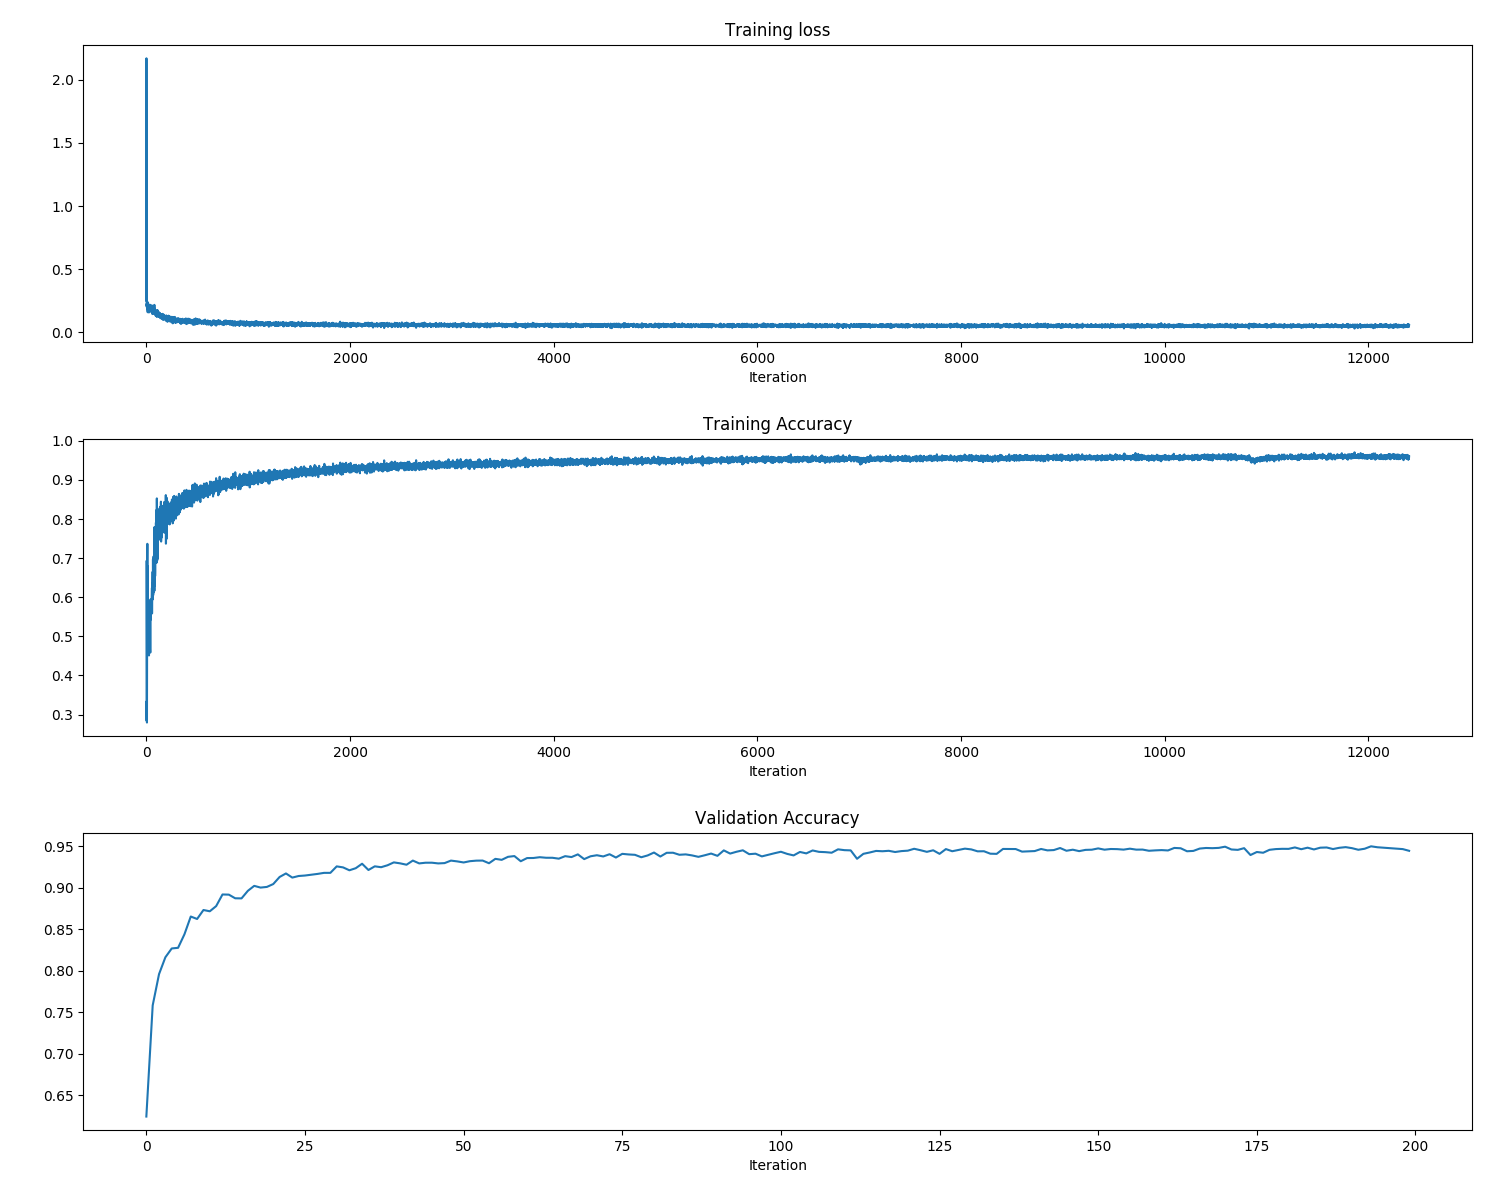

***** test accuracy: 0.950


In [7]:
# Clear old computation graphs
tf.reset_default_graph()
sess = tf.Session()
model = BaseModel(X_train.shape[1:4])
show_graph(tf.get_default_graph())
sess.close()
tf.reset_default_graph()
# Train our sample model
with tf.Session() as sess:
    model = BaseModel(X_train.shape[1:4])
    model.train(sess, X_train, Y_train, X_test, Y_test)
    accuracy = model.evaluate(sess, X_test, Y_test)
    print('***** test accuracy: %.3f' % accuracy)

-----  Baseline  -----
INFO:tensorflow:Restoring parameters from ./misc/baseline_model.ckpt
(178, 176, 176, 1)


<IPython.core.display.Javascript object>


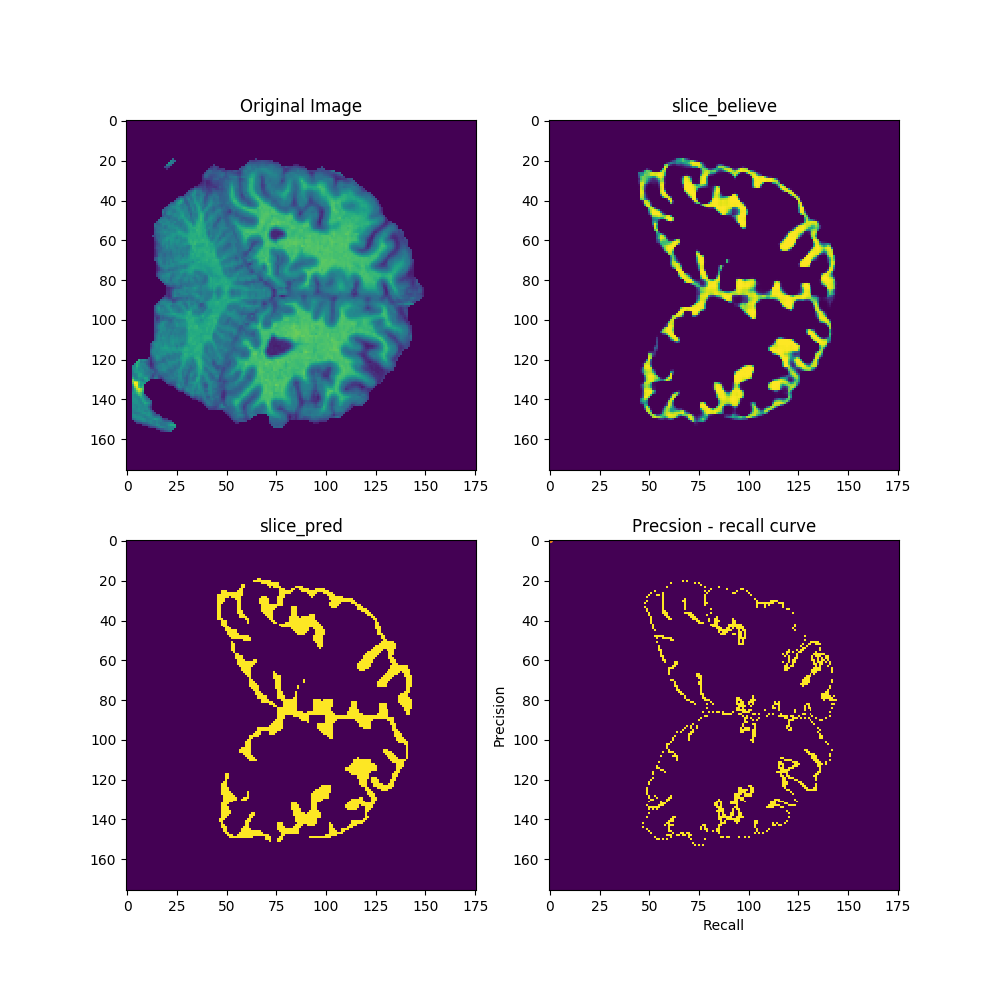

Text(0.5,1,u'Pial')

In [62]:
tf.reset_default_graph()
# Load your model
model = BaseModel(X_test.shape[1:4])
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, model.mode_path)
result, believe = model.get_boudray(sess, X_test, thre=0.5)
sess.close()

print believe.shape

fig = plt.figure(figsize=(10,10)) 
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
slice_num = 50

slice_img = np.squeeze(X_test)[slice_num, :, :]
slice_believe = np.squeeze(believe)[slice_num, :, :]
slice_pred = np.squeeze(result)[slice_num, :, :]
slice_truth = np.squeeze(Y_test)[slice_num, :, :]


ax1.imshow(slice_img)
ax1.set_title('Original Image')
ax2.imshow(slice_believe)
ax2.set_title('slice_believe')
ax3.imshow(slice_pred)
ax3.set_title('slice_pred')
ax4.imshow(slice_truth)
ax4.set_title('Pial')

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95]
max fscore 0.477591025307


<IPython.core.display.Javascript object>


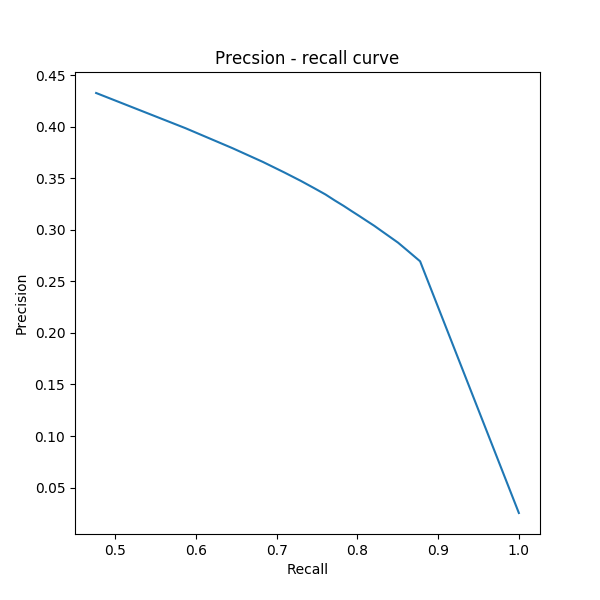

In [67]:
flatBelieve = believe
flatY = Y_test
eps = 1e-12
def get_measure(thre):
    res = (flatBelieve>=thre)
    pr =  float((res*flatY).sum()) / (float(res.sum()) + eps)
    recall = float((res*flatY).sum()) / flatY.sum() 
    fscore =  2.0 / (1.0 / (pr + eps) + 1.0 / (recall + eps))
    return pr, recall, fscore
thres = np.arange(0.0, 1.0, 0.05)
print thres
prArray = []
reArray = []
fsArray = []
for i in thres:
    pr, recall, fscore = get_measure(i)
    prArray.append(pr)
    reArray.append(recall)
    fsArray.append(fscore)

print "max fscore " + str(max(fsArray))

#print prArray
#print reArray
fig = plt.figure(figsize=(6, 6))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precsion - recall curve')
plt.plot(reArray, prArray, '-')
plt.show()